## Introduction

The labels of each face image is embedded in the file name
, formated like [age]_[gender]_[race]_[date&time].jpg

 - **[age]** is an integer from **0 to 116**, indicating the age
 - **[gender]** is either **0 (male) or 1 (female)**
 - **[race]** is an integer from **0 to 4**, denoting _White, Black, Asian, Indian, and Others_ (like Hispanic, Latino, Middle Eastern).
 - **[date&time]** is in the format of **yyyymmddHHMMSSFFF**, showing the date and time an image was collected to UTKFace


Images Shape:
 - **200 x 200 x 3**

## IMPORTS

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re

## Analysis Functions

In [2]:
def load_images_from_folder(folder_path):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    images = []
    
    for filename in filenames:
        img_cv = cv2.imread(os.path.join(folder_path,filename))
        if img_cv is not None:
            img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

In [3]:
def load_image_data_into_dataframe(folderpath):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    df = pd.DataFrame()
    
    for filename in filenames:
        parsed_name = filename.split('_')
        df= df.append({'age' : int(parsed_name[0]),
                       'gender' : parsed_name[1],
                       'race' : parsed_name[2]}, ignore_index=True)
        
    df['gender'] = df['gender'].map({'0': 'male', '1': 'female'})
    df['race'] = df['race'].map({'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'})
    
    return df

In [4]:
def show_images(img_list,img_df):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'Age: {img_df.iloc[i]["age"]}; Race: {img_df.iloc[i]["race"]} Index: {i}',
                  fontweight="bold",fontsize=15)
        plt.imshow(img)

## Dataset Analysis

In [39]:
folder_path = "/Users/Felix/Google Drive/Felix/code/AgeRecognition/raw_data/Faces"

In [40]:
images=load_images_from_folder(folder_path)
print("Images Loaded")

ValueError: invalid literal for int() with base 10: ''

In [25]:
features = load_image_data_into_dataframe(folder_path)
print("Dataframe Loaded")

Dataframe Loaded


In [26]:
print(len(images))
print(len(features))

6
6


## Visualization

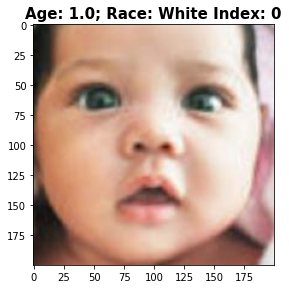

In [29]:
show_images(images[-2:-1],features.iloc[-2:-1])

### Image Resizing

In [ ]:
import Image

img = Image.open("face.jpg")

height = img.shape[0]
width = img.shape[1]

new_width  = 200
new_height = 200
img = img.resize((new_width, new_height), Image.ANTIALIAS)

In [ ]:
plt.imshow(img)

## Distribution

In [ ]:
f = plt.figure(figsize=(25,15))
#bins_value=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120]
bins_value = list(range(0,85,5))

# Age Histogram
f.add_subplot(211)
sns.histplot(data=img_df,x = 'age', bins=bins_value)
plt.title('Age Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(bins_value, rotation = 25)

# Gender Histogram
f.add_subplot(223)
sns.histplot(img_df['gender'])
plt.title('Gender Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

# Race Histogram
f.add_subplot(224)
sns.histplot(img_df['race'])
plt.title('Race Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Race',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks()

plt.show()

## Image Preprocessing

In [ ]:
from PIL import Image
from autocrop import Cropper

In [ ]:
img = Image.open('_felix.png')
a = np.asarray(img)
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

cropper = Cropper(width=200,height=200)
cropped_array = cropper.crop(a)

In [ ]:
cropped_image = Image.fromarray(cropped_array)
cropped_image.save('cropped.png')

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(im)
ax2.imshow(cropped_image)

## Variable Setup

1. Flatten the images **(200,200,3)**
2. Add the target
3. After action 1, a split is performed on each age (randomly). **90/10** per age.
4. The target for the **1st Model is Age.**
5. Age is to be binned on **5y intervals** ([1,5],[6,10],[11,15],...,...,[76,80])
6. To check: Verify if **(Age, Sex and Race)** can also be used as inputs

### 1. Flatenning

In [30]:
print(len(images))
img_array = np.array(images)

6


In [32]:
img_array.shape

(6, 200, 200, 3)

In [34]:
img_array.flatten().reshape(6, 120000).shape

(6, 120000)

In [36]:
images_input = img_array.flatten().reshape(6, 120000)

### 2. Appending Target

In [38]:
print(np.hstack((images_input[0],np.array(features['age'])[0])).shape)
np.hstack((images_input[0],np.array(features['age'])[0]))

(120001,)


array([147., 118.,  78., ...,   0.,   0.,   1.])

In [50]:
#test = images_input.copy()

In [57]:
#test[0]

array([147, 118,  78, ...,   0,   0,   0], dtype=uint8)

In [56]:
np.array([features['age'][0]])

array([1.])

In [68]:
#tt = np.append(test[0] ,np.array([features['age'][0]]))
#tt

#x = np.array([])
#type(x)


numpy.ndarray

In [73]:
x = np.empty([22006, 120000],dtype = "int32")
for i in range(0,2):
    x[i] = np.append(test[i] ,np.array([features['age'][i]]))
    #print(test[-1])

MemoryError: Unable to allocate 9.84 GiB for an array with shape (22006, 120000) and data type int32